<a href="https://colab.research.google.com/github/Skeletrox/dl_notebook/blob/master/DeepQNV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3x3 Treasure Hunter

Uses DQL to perform a treasure hunt given static treasure and enemy. Ideally the agent should avoid any cells that pertain to the enemy and directly go towards the treasure.

## Basic Imports

Numpy for numerical computation

Random for random functions

In [0]:
import numpy as np
import random

## Pytorch imports

Import the neural network module and the Variable class (just for convenience)

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

This is the decision-making neural network. The number of percepts and the number of actions are parameters to modify the input size and the output size based on the problem.

Since this is a neural network that implements Pytorch's Module class, the `forward` method has to be defined, which just describes a single execution of the neural network; a forward propagation step.

In [0]:
class DQN(nn.Module):
  def __init__(self, perceptSize, actionSize):
    super(DQN, self).__init__()
    self.perceptSize = perceptSize
    self.actionSize = actionSize
    self.structure = nn.Sequential(
      nn.Linear(self.perceptSize, 128),
      nn.ReLU(),
      nn.Linear(128, 256),
      nn.ReLU(),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Linear(128, self.actionSize)
    )

  def forward(self, x):
    x = self.structure(x)
    return x

The `ExpBuffer` is used to store experiences in a deque. As training continues, the deque fills up and slowly replaces old observations with newer ones, improving the model performance.

The `push` method adds new samples to the buffer.

The `sample` method samples a number of observations randomly from the buffer and returns them to the training algorithm.

In [0]:
from collections import deque

class ExpBuffer:

  def __init__(self, capacity):
    self.capacity = capacity
    self.buffer = deque(maxlen=capacity)

  def push(self, state, action, reward, nextState, done):
    experience = (state, action, np.array([reward]), nextState, done)
    self.buffer.append(experience)

  def generate(self, batchSize):
    # Build batch
    for i in range(batchSize):
      currState = np.array([np.random.randint(3) for i in range(numInputs)])
      currentAction = np.random.randint(numActions)
      nextState, reward, done = simulate(currState, currentAction)
      self.push(currState, currentAction, reward, nextState, done)

  def sample(self, batchSize):
    stateBatch = []
    actionBatch = []
    rewardBatch = []
    nextStateBatch = []
    doneBatch = []

    batch = random.sample(self.buffer, batchSize)

    for experience in batch:
      state, action, reward, nextState, done = experience
      stateBatch.append(state)
      actionBatch.append(action)
      rewardBatch.append(reward)
      nextStateBatch.append(nextState)
      doneBatch.append(done)

    return (stateBatch, actionBatch, rewardBatch, nextStateBatch, doneBatch)


  def __len__(self):
    return len(self.buffer)

The agent is the decision maker in the field. it contains a network (something similar to the planning component of your brain) and a buffer (comparable to your memory). The agent generates experiences in the buffer and then samples values in order to improve its prediction.

In [0]:
class Agent:


  def __init__(self, perceptSize, numActions, alpha, gamma, bufferSize):
    self.perceptSize = perceptSize
    self.numActions = numActions
    self.alpha = alpha
    self.gamma = gamma
    self.bufferSize = bufferSize
    self.buffer = ExpBuffer(self.bufferSize)
    self.network = DQN(perceptSize, numActions)
    if torch.cuda.is_available():
      print("Exploiting CUDA availability.")
      self.network.cuda()
    self.optimizer = torch.optim.Adam(self.network.parameters(), lr=alpha)
    self.MSE_loss = nn.MSELoss()
    self.losses = []


  def getAction(self, state):
    state = Variable(torch.from_numpy(state).float().unsqueeze(0))
    qvals = self.network.forward(state)
    action = np.argmax(qvals.detach().numpy())
    return action


  def computeLoss(self, batch):
    states, actions, rewards, nextStates, dones = batch
    states = torch.FloatTensor(states).cuda()
    actions = torch.LongTensor(actions).cuda()
    rewards = torch.FloatTensor(rewards).cuda()
    nextStates = torch.FloatTensor(nextStates).cuda()
    dones = torch.FloatTensor(dones).cuda()
    currQ = self.network.forward(states).gather(1, actions.unsqueeze(1))
    currQ = currQ.squeeze(1)
    nextQ = self.network.forward(nextStates)
    maxNextQ = torch.max(nextQ, 1)[0]
    expectedQ = rewards.squeeze(1) + (1 - dones) * self.gamma * maxNextQ
    loss = self.MSE_loss(currQ, expectedQ.detach())
    return loss

  
  def update(self, batchSize):
    self.buffer.generate(batchSize)
    batch = self.buffer.sample(batchSize)
    loss = self.computeLoss(batch)
    self.losses.append(loss.item()) 
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

This is the simulation function. Given a state and an action, it returns the next state, the corresponding reward for the action, and whether or not the state is terminal, i.e. there is nothing more left to do.

In [0]:
# define the simulator function.
def simulate(state, action):

  x = state[0]
  y = state[1]

  badReward = -1000
  goodReward = 1000

  # Got gored by a monster
  if x == 2 and y == 2:
    return state, badReward, True
  
  # Got the treasure
  if x == 2 and y == 0:
    return state, goodReward, True

  if action == 0: # Going Left
    x -= 1
  elif action == 1: # Going Right
    x += 1
  elif action == 2:
    y += 1 # Going down
  else:
    y -= 1 # Going up

  # Define boundary crossing penalties
  reward = 0
  if x < 0:
    x = 0
    reward = badReward
  elif x > 2:
    x = 2
    reward = badReward
  elif y < 0:
    y = 0
    reward = badReward
  elif y > 2:
    y = 2
    reward = badReward
  
  return np.array([x, y]), reward, False

In [0]:
# The inputs are x and y
numInputs = 2

# The Q values are for up, down, left, right
numActions = 4

# Define a learning rate and gamma as well
alpha = 0.005
gamma = 0.9

In [0]:
agent = Agent(numInputs, numActions, alpha, gamma, 10000)

Exploiting CUDA availability.


In [0]:
# how many epochs?
epochs = 10000

# what is the batch size?
batchSize = 100

In [0]:
values = []

for i in range(1, epochs+1):
  agent.update(batchSize)
  z = np.mean(agent.losses[-batchSize:])
  values.append(z)
  if i % 100 == 0:
    print("Epoch number: {}, Loss: {}".format(i, z))

Epoch number: 100, Loss: 285534.04875
Epoch number: 200, Loss: 148133.94203125
Epoch number: 300, Loss: 71446.19115234374
Epoch number: 400, Loss: 39468.0181640625
Epoch number: 500, Loss: 23265.26771484375
Epoch number: 600, Loss: 9292.081821289063
Epoch number: 700, Loss: 3031.8421228027346
Epoch number: 800, Loss: 2551.1877215576174
Epoch number: 900, Loss: 4047.5766284179685
Epoch number: 1000, Loss: 6816.394985351562
Epoch number: 1100, Loss: 3022.528687133789
Epoch number: 1200, Loss: 7792.6376599121095
Epoch number: 1300, Loss: 5737.8447265625
Epoch number: 1400, Loss: 13024.30166015625
Epoch number: 1500, Loss: 14122.533676757812
Epoch number: 1600, Loss: 13743.580795898437
Epoch number: 1700, Loss: 9176.350712890626
Epoch number: 1800, Loss: 1182.1974891662599
Epoch number: 1900, Loss: 542.5534422302246
Epoch number: 2000, Loss: 198.79090745925905
Epoch number: 2100, Loss: 39.292420110702516
Epoch number: 2200, Loss: 7.7038589334487915
Epoch number: 2300, Loss: 5.0623808896541

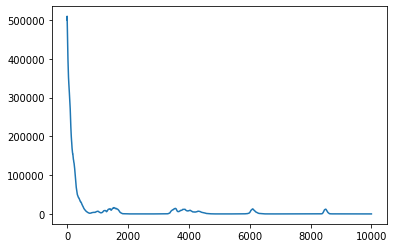

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(values)

In [0]:
from itertools import product
predicted = None
with torch.no_grad():
  indices = [i for i in range(3)]
  for x, y in product(indices, indices):
    vals = np.array([x, y])
    predicted = agent.network(Variable(torch.from_numpy(vals).float().cuda())).cpu().numpy()
    # predicted = agent.network(Variable(torch.from_numpy(vals)))
    maxRewardResults = np.argmax(predicted)
    print("For x = {}; y = {}; Predicted rewards: {}".format(x, y, predicted))

For x = 0; y = 0; Predicted rewards: [-271.2611   810.7267   656.4166  -270.40433]
For x = 0; y = 1; Predicted rewards: [-344.12933  729.875    591.1323   729.81854]
For x = 0; y = 2; Predicted rewards: [-409.5605   656.98566 -409.20184  657.09143]
For x = 1; y = 0; Predicted rewards: [ 729.1149   900.6348   729.3381  -189.65413]
For x = 1; y = 1; Predicted rewards: [656.27167 810.5126  656.6403  810.4524 ]
For x = 1; y = 2; Predicted rewards: [ 590.84045 -899.14435 -343.72482  729.66815]
For x = 2; y = 0; Predicted rewards: [ 999.8701  1000.41187 1000.135    999.68427]
For x = 2; y = 1; Predicted rewards: [ 729.18604 -189.46783 -899.32227  900.831  ]
For x = 2; y = 2; Predicted rewards: [ -999.15027  -999.467   -1000.1943   -998.8887 ]
